In [2]:
import os
import sys
import time
import copy

import numpy as np
import math
import random
import matplotlib.pyplot as plt

import functools
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

import pickle

import datasets, models
import importlib
importlib.reload(models)
import init, measures

In [5]:
from dataclasses import dataclass
@dataclass
class config:

    device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

    dataset = 'rhm'
    mode = None
    num_features = 32
    num_classes = 32
    num_synonyms = 32
    tuple_size = 2
    num_layers = 2
    seed_rules = 2362346
    num_tokens = 4 # context length, tuple_size**num_layers for the full input

    train_size = 131072
    batch_size = 256
    accumulation = 1
    test_size = 32768
    seed_sample = 34534
    replacement = False

    input_format = 'onehot'
    whitening = 1

    model = 'hcnn'
    depth = 2
    width = 1024
    filter_size = 2
    bias = False
    seed_model = 359

    optim = 'sgd'
    lr = 1.0
    momentum = 0.0
    scheduler = None
    scheduler_time = 1024
    max_epochs = 1024

    print_freq = 64
    save_freq = 3
    loss_threshold = 1e-3

    outname = 'test'

config.bonus = dict.fromkeys(['rules'])#False # dict.fromkeys(['noise', 'synonyms', 'size'])

config.zipf = None
config.layer = config.num_layers

config.num_data = config.num_classes*config.num_synonyms**((config.tuple_size**config.num_layers-1)//(config.tuple_size-1))
config.input_size = config.tuple_size**config.num_layers
config.num_batches = config.train_size//config.batch_size
config.max_iters = config.max_epochs*config.num_batches

scales = []
for i in range(config.num_layers):
    scales.append(config.num_classes*config.num_synonyms**(2*i+1)/(1.-config.num_synonyms/(config.num_features**config.tuple_size)))
print(config.num_data, config.num_classes*config.num_synonyms**(config.num_layers), scales)

print(config.device)

1048576 32768 [1057.032258064516, 1082401.0322580645]
mps


In [9]:
train_loader, test_loader = init.init_data(config)

if config.bonus:

    if 'rules' in config.bonus:
        print(config.bonus['rules'][0].size())

    if 'synonyms' in config.bonus:
        for k in config.bonus['synonyms']:
            print(k, config.bonus['synonyms'][k][1].argmax(dim=1)+1)
    if 'noise' in config.bonus:
        for k in config.bonus['noise']:
            print(k, config.bonus['noise'][k][1].argmax(dim=1)+1)

torch.Size([32, 32, 2])


In [103]:
for x, y in train_loader:
    print(x.size(), y.size(), x.device)

torch.Size([256, 32, 4]) torch.Size([256]) cpu
torch.Size([256, 32, 4]) torch.Size([256]) cpu
torch.Size([256, 32, 4]) torch.Size([256]) cpu
torch.Size([256, 32, 4]) torch.Size([256]) cpu
torch.Size([256, 32, 4]) torch.Size([256]) cpu
torch.Size([256, 32, 4]) torch.Size([256]) cpu
torch.Size([256, 32, 4]) torch.Size([256]) cpu
torch.Size([256, 32, 4]) torch.Size([256]) cpu
torch.Size([256, 32, 4]) torch.Size([256]) cpu
torch.Size([256, 32, 4]) torch.Size([256]) cpu
torch.Size([256, 32, 4]) torch.Size([256]) cpu
torch.Size([256, 32, 4]) torch.Size([256]) cpu
torch.Size([256, 32, 4]) torch.Size([256]) cpu
torch.Size([256, 32, 4]) torch.Size([256]) cpu
torch.Size([256, 32, 4]) torch.Size([256]) cpu
torch.Size([256, 32, 4]) torch.Size([256]) cpu
torch.Size([256, 32, 4]) torch.Size([256]) cpu
torch.Size([256, 32, 4]) torch.Size([256]) cpu
torch.Size([256, 32, 4]) torch.Size([256]) cpu
torch.Size([256, 32, 4]) torch.Size([256]) cpu
torch.Size([256, 32, 4]) torch.Size([256]) cpu
torch.Size([2

In [104]:
model = init.init_model(config)
model0 = copy.deepcopy( model)
param_count = sum([p.numel() for p in model.parameters()])
print(param_count)

2195456


In [105]:
criterion, optimizer, scheduler = init.init_training( model, config)

In [106]:
%%time
dynamics, best = init.init_output(model, criterion, train_loader, test_loader, config)
print(dynamics[0])

if config.bonus:
    if 'synonyms' in config.bonus:
        for l in range(config.depth+1):
            for k in dynamics[0]['synonyms'][l].keys():
                print(f'depth {l}, level {k}, sensitivity: ', dynamics[0]['synonyms'][l][k].mean().item())
    if 'noise' in config.bonus:
        for l in range(config.depth+1):
            for k in dynamics[0]['noise'][l].keys():
                print(f'depth {l}, level {k}, sensitivity: ', dynamics[0]['noise'][l][k].mean().item())

{'t': 0, 'trainloss': 3.465756938792765, 'trainacc': 0.030975341796875, 'testloss': 3.46572582423687, 'testacc': 0.03302001953125}
CPU times: user 2.19 s, sys: 310 ms, total: 2.5 s
Wall time: 6.74 s


In [107]:
# config.print_freq = 256
# config.save_freq = 3

print_ckpts, save_ckpts = init.init_loglinckpt( config.print_freq, config.max_iters, freq=config.save_freq)
print_ckpt = next(print_ckpts)
save_ckpt = next(save_ckpts)

step = 0

## TRAINING

In [108]:
for epoch in range(config.max_epochs):

    model.train()
    optimizer.zero_grad()
    running_loss = 0.

    for batch_idx, (inputs, targets) in enumerate(train_loader):

        outputs = model(inputs.to(config.device))
        loss = criterion(outputs, targets.to(config.device))
        running_loss += loss.item()
        loss /= config.accumulation
        loss.backward()

        if ((batch_idx+1)%config.accumulation==0):
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            step += 1

            if step==print_ckpt:

                test_loss, test_acc = measures.test(model, test_loader, config.device)

                if test_loss<best['loss']: # update best model if loss is smaller
                    best['step'] = step
                    best['loss'] = test_loss
                    best['model'] = copy.deepcopy( model.state_dict())

                print('step : ',step, '\t train loss: {:06.4f}'.format(running_loss/(batch_idx+1)), ',test loss: {:06.4f}'.format(test_loss))
                print_ckpt = next(print_ckpts)

                if step>=save_ckpt:

                    print(f'Checkpoint at step {step}, saving data ...')

                    train_loss, train_acc = measures.test(model, train_loader, config.device)
                    save_dict = {'t': step, 'trainloss': train_loss, 'trainacc': train_acc, 'testloss': test_loss, 'testacc': test_acc}
                    if config.bonus:
                        if 'synonyms' in config.bonus:
                            save_dict['synonyms'] = measures.sensitivity( model, config.bonus['features'], config.bonus['synonyms'])
                        if 'noise' in config.bonus:
                            save_dict['noise'] = measures.sensitivity( model, config.bonus['features'], config.bonus['noise'])
                    dynamics.append(save_dict)
                    save_ckpt = next(save_ckpts)


    if (running_loss/(batch_idx+1)) <= config.loss_threshold:

        train_loss, train_acc = measures.test(model, train_loader, config.device)
        save_dict = {'t': step, 'trainloss': train_loss, 'trainacc': train_acc, 'testloss': test_loss, 'testacc': test_acc}
        if config.bonus:
            if 'synonyms' in config.bonus:
                save_dict['synonyms'] = measures.sensitivity( model, config.bonus['features'], config.bonus['synonyms'])
            if 'noise' in config.bonus:
                save_dict['noise'] = measures.sensitivity( model, config.bonus['features'], config.bonus['noise'])
        dynamics.append(save_dict)

        break

step :  1 	 train loss: 3.4654 ,test loss: 3.4657
Checkpoint at step 1, saving data ...
step :  2 	 train loss: 3.4657 ,test loss: 3.4657
Checkpoint at step 2, saving data ...
step :  3 	 train loss: 3.4657 ,test loss: 3.4657
Checkpoint at step 3, saving data ...
step :  4 	 train loss: 3.4656 ,test loss: 3.4657
Checkpoint at step 4, saving data ...
step :  5 	 train loss: 3.4657 ,test loss: 3.4657
Checkpoint at step 5, saving data ...
step :  6 	 train loss: 3.4657 ,test loss: 3.4657
Checkpoint at step 6, saving data ...
step :  7 	 train loss: 3.4657 ,test loss: 3.4657
Checkpoint at step 7, saving data ...
step :  8 	 train loss: 3.4657 ,test loss: 3.4657
Checkpoint at step 8, saving data ...
step :  10 	 train loss: 3.4657 ,test loss: 3.4657
Checkpoint at step 10, saving data ...
step :  13 	 train loss: 3.4657 ,test loss: 3.4657
Checkpoint at step 13, saving data ...
step :  16 	 train loss: 3.4657 ,test loss: 3.4657
Checkpoint at step 16, saving data ...
step :  20 	 train loss: 3

KeyboardInterrupt: 

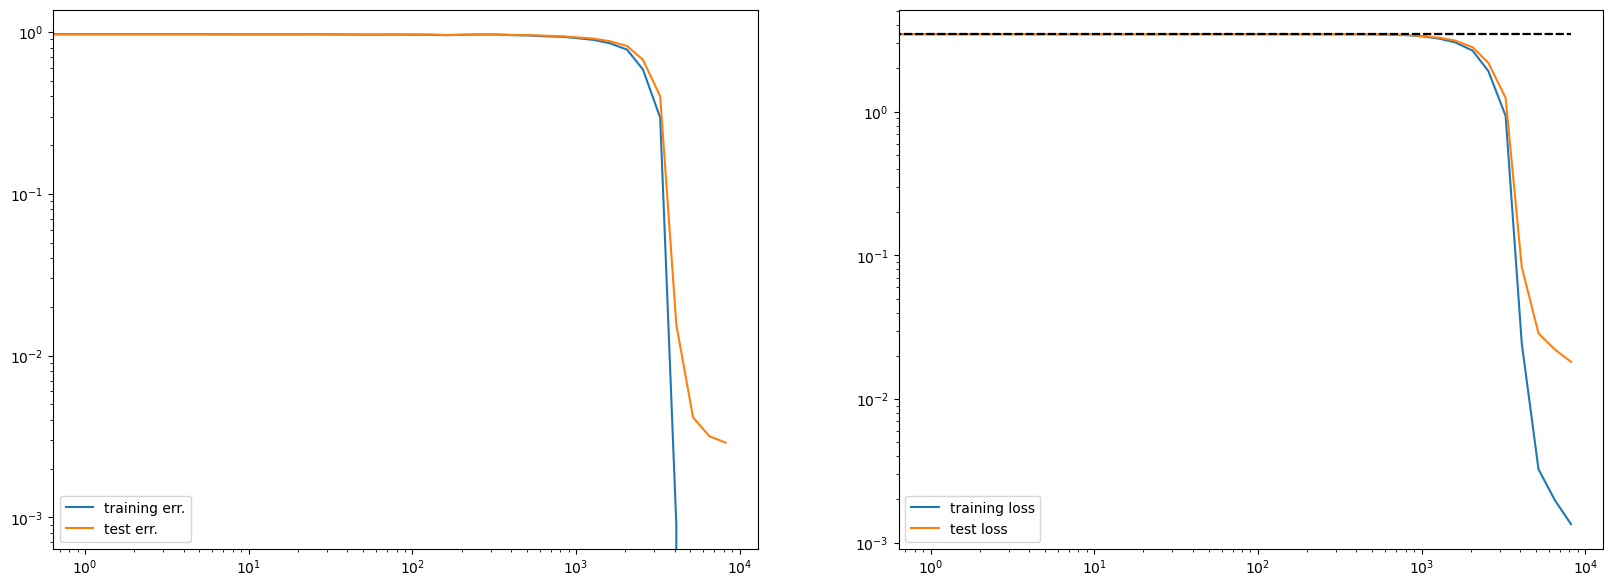

In [109]:
import math

fig, ax = plt.subplots(1, 2, figsize=(20,7))

ax[0].plot([d['t'] for d in dynamics], [1.-d['trainacc'] for d in dynamics], f'C0', label='training err.')
ax[0].plot([d['t'] for d in dynamics], [1.-d['testacc'] for d in dynamics], f'C1', label='test err.')

ax[1].plot([d['t'] for d in dynamics], [d['trainloss'] for d in dynamics], f'C0', label='training loss')
ax[1].plot([d['t'] for d in dynamics], [d['testloss'] for d in dynamics], f'C1', label='test loss')

L = config.num_layers
v = config.num_features
m = config.num_synonyms
s = config.tuple_size
time = [d['t'] for d in dynamics]
for k in range(L+1):
    compatible = (v-1)*((v**s-m*v)/(v**s-1-m*(v-1)))*((m*(v-1))/(v**s-1))**k + (v-1)*(m-1)/(v**s-1-m*(v-1))
    ax[1].plot([t for t in time], [math.log(1+compatible) for t in time], 'k--')


ax[0].legend()
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[1].legend()
ax[1].set_xscale('log')
ax[1].set_yscale('log')
# ax[1].set_ylim(1e-1,1e1)

In [10]:
if config.bonus:
    if 'synonyms' in config.bonus:
        for k in range(config.depth+1):
            for l in range(1,config.num_layers):
                print(f'depth {k}, level {l}, sensitivity: ', dynamics[0]['synonyms'][k][l].mean().item())

depth 0, level 1, sensitivity:  0.7924718856811523
depth 0, level 2, sensitivity:  0.5810505747795105
depth 1, level 1, sensitivity:  0.7942036986351013
depth 1, level 2, sensitivity:  0.5945730209350586
depth 2, level 1, sensitivity:  0.7952446937561035
depth 2, level 2, sensitivity:  0.5942511558532715
depth 3, level 1, sensitivity:  0.7871344089508057
depth 3, level 2, sensitivity:  0.5924810767173767


dict_keys([0, 1, 2, 3])
dict_keys([3, 2, 1])


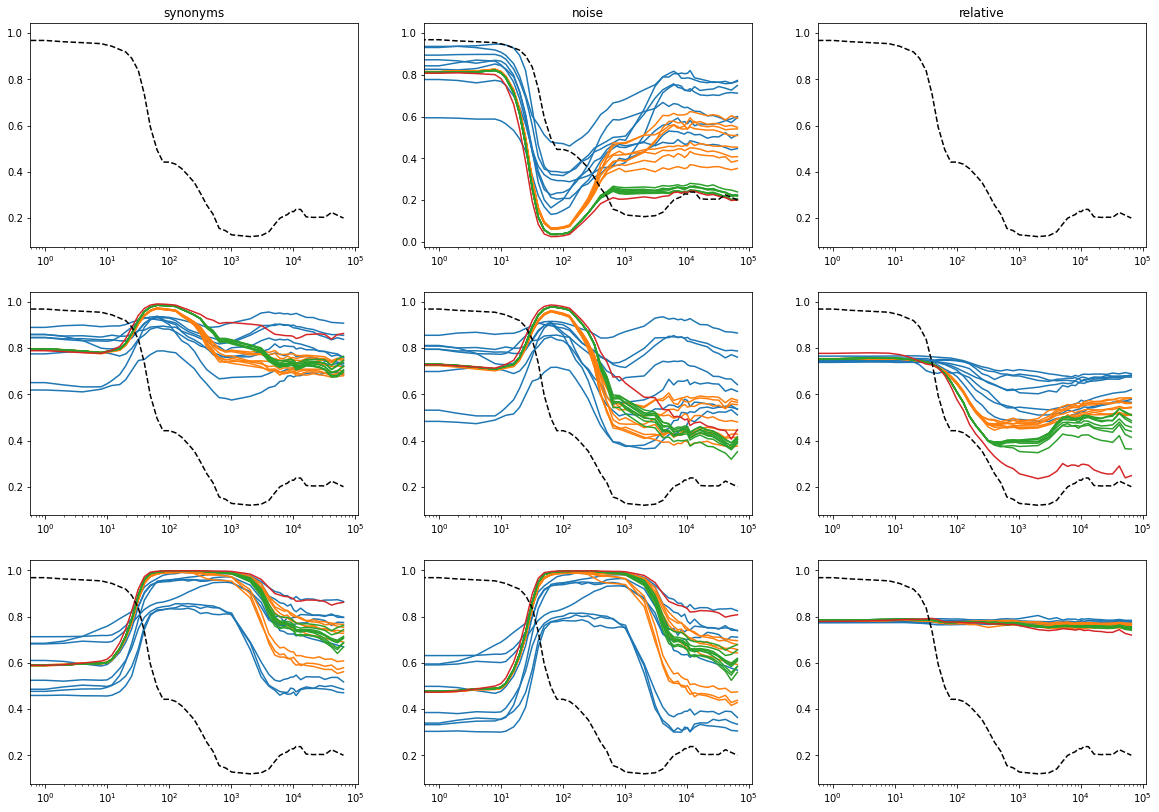

In [11]:
fig, ax = plt.subplots((config.num_layers), 3, figsize=(20,14))


print(dynamics[-1]['synonyms'].keys())
print(dynamics[-1]['synonyms'][3].keys())

ax[0][0].set_title('synonyms')
ax[0][1].set_title('noise')
ax[0][2].set_title('relative')

for k in range(config.depth+1):

    l = 0
    ax[0][1].plot([d['t'] for d in dynamics], [d['noise'][k][l].to('cpu') for d in dynamics], f'C{k}' , label=f'{k}-th rep.')
    ax[0][0].set_xscale('log')
    ax[0][1].set_xscale('log')
    ax[0][2].set_xscale('log')

    
    for l in range(1,config.num_layers):

        ax[l][0].plot([d['t'] for d in dynamics], [d['synonyms'][k][l].to('cpu') for d in dynamics], f'C{k}' , label=f'{k}-th rep.')
        ax[l][1].plot([d['t'] for d in dynamics], [d['noise'][k][l].to('cpu') for d in dynamics], f'C{k}' , label=f'{k}-th rep.')
        ax[l][2].plot([d['t'] for d in dynamics], [(1.-d['synonyms'][k][l].to('cpu'))/((1.-d['noise'][k][l].to('cpu'))) for d in dynamics], f'C{k}' , label=f'{k}-th rep.')

        ax[l][0].set_xscale('log')
        ax[l][1].set_xscale('log')
        ax[l][2].set_xscale('log')

init_loss = dynamics[0]['testloss']
for l in range(config.num_layers):

    ax[l][0].plot([d['t'] for d in dynamics], [d['testloss']/init_loss for d in dynamics], f'k--')
    ax[l][1].plot([d['t'] for d in dynamics], [d['testloss']/init_loss for d in dynamics], f'k--')
    ax[l][2].plot([d['t'] for d in dynamics], [d['testloss']/init_loss for d in dynamics], f'k--')